# **NLP News avec FinBERT**

## Installation des dépendances

In [5]:
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Vérifier si GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device: {device}")
if torch.cuda.is_available():
    print(f"GPU détecté: {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Utilisation du device: cuda
GPU détecté: NVIDIA GeForce RTX 3070
Mémoire GPU disponible: 8.59 GB


In [6]:
# 1. Chargement de TOUTES les données brutes (sans split préalable)
import json

def load_yahoo_data(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Charger TOUTES les données Yahoo (train + dev + test)
train_data_yahoo = load_yahoo_data("data/yahoo/train.data")
dev_data_yahoo = load_yahoo_data("data/yahoo/dev.data")
test_data_yahoo = load_yahoo_data("data/yahoo/test.data")

# Combiner toutes les données Yahoo
all_yahoo_data = train_data_yahoo + dev_data_yahoo + test_data_yahoo

print("="*70)
print("CHARGEMENT DES DONNÉES BRUTES")
print("="*70)
print(f"Yahoo News (total) : {len(all_yahoo_data)} articles bruts")
print("(train + dev + test combinés avant split)")


CHARGEMENT DES DONNÉES BRUTES
Yahoo News (total) : 160515 articles bruts
(train + dev + test combinés avant split)


In [7]:
# 2. Chargement et combinaison des 3 sources COMPLÈTES
from sklearn.model_selection import train_test_split

def preprocess_yahoo_data(data):
    """Prétraite les données Yahoo News"""
    texts = []
    labels = []
    for article in data:
        title = article.get('title', '')
        paras = article.get('paras', [])
        text = title + ' ' + ' '.join(paras)
        
        cmts = article.get('cmts', [])
        if not cmts:
            continue
        sentiments = [cmt.get('sentiment', 'NEUTRAL') for cmt in cmts]
        pos_count = sentiments.count('POSITIVE')
        neg_count = sentiments.count('NEGATIVE')
        neu_count = sentiments.count('NEUTRAL')
        
        if pos_count > neg_count and pos_count > neu_count:
            label = 1  # Positive
        elif neg_count > pos_count and neg_count > neu_count:
            label = 0  # Negative
        else:
            continue  # Skip neutral
        
        texts.append(text)
        labels.append(label)
    
    return texts, labels


def load_all_data_sources():
    """
    Charge les 3 sources de données et les combine AVANT le split
    """
    all_texts = []
    all_labels = []
    sources_info = []
    
    print("\n" + "="*70)
    print("CHARGEMENT DES 3 SOURCES DE DONNÉES")
    print("="*70)
    
    # ========================================
    # 1. YAHOO NEWS (toutes les données)
    # ========================================
    print("\n📰 [1/3] Yahoo News...")
    yahoo_texts, yahoo_labels = preprocess_yahoo_data(all_yahoo_data)
    print(f"   ✓ {len(yahoo_texts)} articles extraits")
    print(f"      Positif: {sum(yahoo_labels)} | Négatif: {len(yahoo_labels) - sum(yahoo_labels)}")
    
    all_texts.extend(yahoo_texts)
    all_labels.extend(yahoo_labels)
    sources_info.append(('Yahoo News', len(yahoo_texts)))
    
    # ========================================
    # 2. ALL-DATA.CSV
    # ========================================
    print("\n📊 [2/3] all-data.csv...")
    encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    df_alldata = None
    
    for encoding in encodings_to_try:
        try:
            df_alldata = pd.read_csv(
                'data/all-data.csv',
                header=None,
                names=['sentiment', 'text'],
                encoding=encoding,
                on_bad_lines='skip'
            )
            print(f"   ✓ Chargé avec encodage: {encoding}")
            break
        except:
            continue
    
    if df_alldata is not None:
        df_alldata = df_alldata[df_alldata['sentiment'].isin(['positive', 'negative'])]
        alldata_texts = df_alldata['text'].tolist()
        alldata_labels = [1 if s == 'positive' else 0 for s in df_alldata['sentiment']]
        
        print(f"   ✓ {len(alldata_texts)} phrases extraites")
        print(f"      Positif: {sum(alldata_labels)} | Négatif: {len(alldata_labels) - sum(alldata_labels)}")
        
        all_texts.extend(alldata_texts)
        all_labels.extend(alldata_labels)
        sources_info.append(('all-data.csv', len(alldata_texts)))
    else:
        print("   ⚠️ Impossible de charger all-data.csv")
        sources_info.append(('all-data.csv', 0))
    
    # ========================================
    # 3. FINANCIAL PHRASE BANK
    # ========================================
    print("\n🏦 [3/3] FinancialPhraseBank...")
    
    phrasebank_texts = []
    phrasebank_labels = []
    
    try:
        with open('data/FinancialPhraseBank/Sentences_AllAgree.txt', 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                if '@' in line:
                    try:
                        text, sentiment = line.strip().rsplit('@', 1)
                        if sentiment in ['positive', 'negative']:
                            phrasebank_texts.append(text)
                            phrasebank_labels.append(1 if sentiment == 'positive' else 0)
                    except ValueError:
                        continue
        
        print(f"   ✓ {len(phrasebank_texts)} phrases extraites")
        print(f"      Positif: {sum(phrasebank_labels)} | Négatif: {len(phrasebank_labels) - sum(phrasebank_labels)}")
        
        all_texts.extend(phrasebank_texts)
        all_labels.extend(phrasebank_labels)
        sources_info.append(('PhraseBank', len(phrasebank_texts)))
    except Exception as e:
        print(f"   ⚠️ Erreur: {e}")
        sources_info.append(('PhraseBank', 0))
    
    # ========================================
    # 4. STATISTIQUES GLOBALES
    # ========================================
    print("\n" + "="*70)
    print("📊 DONNÉES COMBINÉES (AVANT SPLIT)")
    print("="*70)
    for source, count in sources_info:
        print(f"   {source:<20} : {count:>6} exemples")
    print(f"   " + "-"*66)
    print(f"   TOTAL                : {len(all_texts):>6} exemples")
    print(f"\n📈 Distribution globale :")
    print(f"   Positif : {sum(all_labels):>6} ({sum(all_labels)/len(all_labels)*100:>5.1f}%)")
    print(f"   Négatif : {len(all_labels)-sum(all_labels):>6} ({(len(all_labels)-sum(all_labels))/len(all_labels)*100:>5.1f}%)")
    print("="*70)
    
    return all_texts, all_labels, sources_info

# Charger toutes les données
all_combined_texts, all_combined_labels, sources_summary = load_all_data_sources()



CHARGEMENT DES 3 SOURCES DE DONNÉES

📰 [1/3] Yahoo News...
   ✓ 6382 articles extraits
      Positif: 457 | Négatif: 5925

📊 [2/3] all-data.csv...
   ✓ Chargé avec encodage: latin-1
   ✓ 1967 phrases extraites
      Positif: 1363 | Négatif: 604

🏦 [3/3] FinancialPhraseBank...
   ✓ 873 phrases extraites
      Positif: 570 | Négatif: 303

📊 DONNÉES COMBINÉES (AVANT SPLIT)
   Yahoo News           :   6382 exemples
   all-data.csv         :   1967 exemples
   PhraseBank           :    873 exemples
   ------------------------------------------------------------------
   TOTAL                :   9222 exemples

📈 Distribution globale :
   Positif :   2390 ( 25.9%)
   Négatif :   6832 ( 74.1%)


In [8]:
# 3. SPLIT STRATIFIÉ EN TRAIN/DEV/TEST (70/15/15)
from sklearn.utils import resample
from collections import Counter

print("\n" + "="*70)
print("SPLIT STRATIFIÉ DES DONNÉES")
print("="*70)

# Convertir en arrays numpy
all_texts_array = np.array(all_combined_texts)
all_labels_array = np.array(all_combined_labels)

# Split 1 : Séparer train (70%) du reste (30%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    all_texts_array,
    all_labels_array,
    test_size=0.30,
    random_state=42,
    stratify=all_labels_array  # Split stratifié pour garder la distribution
)

# Split 2 : Séparer dev (15%) et test (15%) depuis les 30% restants
dev_texts, test_texts, dev_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.50,  # 50% des 30% = 15% du total
    random_state=42,
    stratify=temp_labels
)

# Convertir en listes
train_texts = train_texts.tolist()
train_labels = train_labels.tolist()
dev_texts = dev_texts.tolist()
dev_labels = dev_labels.tolist()
test_texts = test_texts.tolist()
test_labels = test_labels.tolist()

print(f"\n✅ Split effectué :")
print(f"   Train : {len(train_texts):>5} exemples ({len(train_texts)/len(all_combined_texts)*100:.1f}%)")
print(f"   Dev   : {len(dev_texts):>5} exemples ({len(dev_texts)/len(all_combined_texts)*100:.1f}%)")
print(f"   Test  : {len(test_texts):>5} exemples ({len(test_texts)/len(all_combined_texts)*100:.1f}%)")

# Afficher les distributions
for name, labels in [("Train", train_labels), ("Dev", dev_labels), ("Test", test_labels)]:
    pos = sum(labels)
    neg = len(labels) - pos
    print(f"\n   {name} - Distribution :")
    print(f"      Positif : {pos} ({pos/len(labels)*100:.1f}%)")
    print(f"      Négatif : {neg} ({neg/len(labels)*100:.1f}%)")

print("\n" + "="*70)
print("ÉQUILIBRAGE DU TRAIN SET UNIQUEMENT")
print("="*70)

# Fonction d'équilibrage
def balance_dataset(texts, labels, dataset_name):
    """Équilibre en sous-échantillonnant la classe majoritaire"""
    texts = np.array(texts)
    labels = np.array(labels)
    
    class_counts = Counter(labels)
    print(f"\n   {dataset_name} - AVANT équilibrage :")
    print(f"      Positif : {class_counts[1]} | Négatif : {class_counts[0]}")
    print(f"      Ratio   : {max(class_counts.values())/min(class_counts.values()):.2f}:1")
    
    # Séparer les classes
    idx_neg = np.where(labels == 0)[0]
    idx_pos = np.where(labels == 1)[0]
    
    # Sous-échantillonner la classe majoritaire
    min_class_size = min(len(idx_neg), len(idx_pos))
    
    if len(idx_neg) > len(idx_pos):
        idx_neg_sampled = resample(idx_neg, n_samples=min_class_size, random_state=42, replace=False)
        idx_pos_sampled = idx_pos
    else:
        idx_pos_sampled = resample(idx_pos, n_samples=min_class_size, random_state=42, replace=False)
        idx_neg_sampled = idx_neg
    
    # Combiner et mélanger
    balanced_indices = np.concatenate([idx_neg_sampled, idx_pos_sampled])
    np.random.shuffle(balanced_indices)
    
    texts_balanced = texts[balanced_indices].tolist()
    labels_balanced = labels[balanced_indices].tolist()
    
    class_counts_after = Counter(labels_balanced)
    print(f"\n   {dataset_name} - APRÈS équilibrage :")
    print(f"      Positif : {class_counts_after[1]} | Négatif : {class_counts_after[0]}")
    print(f"      Ratio   : 1:1 ✓")
    
    return texts_balanced, labels_balanced

# Équilibrer uniquement le train
train_texts, train_labels = balance_dataset(train_texts, train_labels, "TRAIN")

print("\n" + "="*70)
print("📋 RÉSUMÉ FINAL DES DATASETS")
print("="*70)
print(f"   Train  : {len(train_texts):>5} exemples (ÉQUILIBRÉ 50/50)")
print(f"   Dev    : {len(dev_texts):>5} exemples (distribution naturelle)")
print(f"   Test   : {len(test_texts):>5} exemples (distribution naturelle)")
print("\n⚠️  IMPORTANT : Dev et Test gardent leur distribution naturelle")
print("   pour une évaluation réaliste et non biaisée.")
print("="*70)



SPLIT STRATIFIÉ DES DONNÉES

✅ Split effectué :
   Train :  6455 exemples (70.0%)
   Dev   :  1383 exemples (15.0%)
   Test  :  1384 exemples (15.0%)

   Train - Distribution :
      Positif : 1673 (25.9%)
      Négatif : 4782 (74.1%)

   Dev - Distribution :
      Positif : 358 (25.9%)
      Négatif : 1025 (74.1%)

   Test - Distribution :
      Positif : 359 (25.9%)
      Négatif : 1025 (74.1%)

ÉQUILIBRAGE DU TRAIN SET UNIQUEMENT

   TRAIN - AVANT équilibrage :
      Positif : 1673 | Négatif : 4782
      Ratio   : 2.86:1

   TRAIN - APRÈS équilibrage :
      Positif : 1673 | Négatif : 1673
      Ratio   : 1:1 ✓

📋 RÉSUMÉ FINAL DES DATASETS
   Train  :  3346 exemples (ÉQUILIBRÉ 50/50)
   Dev    :  1383 exemples (distribution naturelle)
   Test   :  1384 exemples (distribution naturelle)

⚠️  IMPORTANT : Dev et Test gardent leur distribution naturelle
   pour une évaluation réaliste et non biaisée.



VISUALISATION DES DISTRIBUTIONS


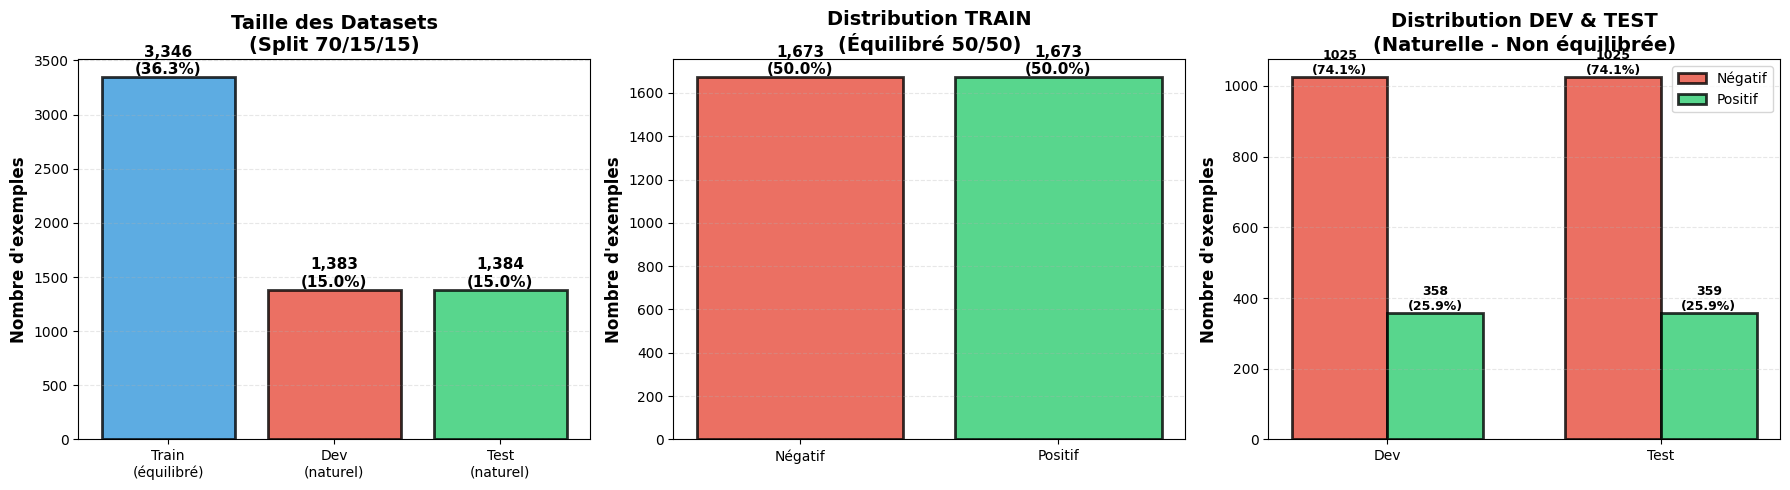


📊 TABLEAU RÉCAPITULATIF

Dataset       Total    Positif    Négatif    Équilibré
----------------------------------------------------------------------
Train          3346       1673 ( 50.0%)       1673 ( 50.0%)         ✅ Oui
Dev            1383        358 ( 25.9%)       1025 ( 74.1%)         ❌ Non
Test           1384        359 ( 25.9%)       1025 ( 74.1%)         ❌ Non

✅ Les 3 datasets proviennent des MÊMES sources
   → Pas de distribution shift entre train/dev/test
   → Métriques d'évaluation fiables et représentatives


In [9]:
# 4. VISUALISATION DES DATASETS FINAUX
from collections import Counter

print("\n" + "="*70)
print("VISUALISATION DES DISTRIBUTIONS")
print("="*70)

# Créer une figure avec 3 sous-graphiques
fig = plt.figure(figsize=(18, 5))

# Graphique 1 : Comparaison des tailles
ax1 = plt.subplot(1, 3, 1)
datasets = ['Train\n(équilibré)', 'Dev\n(naturel)', 'Test\n(naturel)']
sizes = [len(train_texts), len(dev_texts), len(test_texts)]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars1 = ax1.bar(datasets, sizes, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Nombre d\'exemples', fontsize=12, fontweight='bold')
ax1.set_title('Taille des Datasets\n(Split 70/15/15)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bar, size in zip(bars1, sizes):
    height = bar.get_height()
    percentage = size / len(all_combined_texts) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{size:,}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Graphique 2 : Distribution Train (équilibré)
ax2 = plt.subplot(1, 3, 2)
train_counts = Counter(train_labels)
labels_train = ['Négatif', 'Positif']
values_train = [train_counts[0], train_counts[1]]

bars2 = ax2.bar(labels_train, values_train, color=['#e74c3c', '#2ecc71'], 
               alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Nombre d\'exemples', fontsize=12, fontweight='bold')
ax2.set_title('Distribution TRAIN\n(Équilibré 50/50)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar, val in zip(bars2, values_train):
    height = bar.get_height()
    percentage = val / len(train_labels) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Graphique 3 : Distributions Dev & Test (naturelles)
ax3 = plt.subplot(1, 3, 3)

dev_counts = Counter(dev_labels)
test_counts = Counter(test_labels)

# Créer les groupes Dev et Test avec leurs distributions
datasets_names = ['Dev', 'Test']
x = np.arange(len(datasets_names))
width = 0.35

# Barres pour Négatifs (rouge) et Positifs (vert)
neg_values = [dev_counts[0], test_counts[0]]
pos_values = [dev_counts[1], test_counts[1]]

bars3_neg = ax3.bar(x - width/2, neg_values, width, 
                    label='Négatif', color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=2)
bars3_pos = ax3.bar(x + width/2, pos_values, width,
                    label='Positif', color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=2)

ax3.set_ylabel('Nombre d\'exemples', fontsize=12, fontweight='bold')
ax3.set_title('Distribution DEV & TEST\n(Naturelle - Non équilibrée)', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(datasets_names)
ax3.legend()
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Annotations avec pourcentages
for i, (bar_neg, bar_pos, dataset_name) in enumerate(zip(bars3_neg, bars3_pos, datasets_names)):
    total = neg_values[i] + pos_values[i]
    
    # Annotation Négatif
    height_neg = bar_neg.get_height()
    pct_neg = (height_neg / total) * 100
    ax3.text(bar_neg.get_x() + bar_neg.get_width()/2., height_neg,
            f'{int(height_neg)}\n({pct_neg:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Annotation Positif
    height_pos = bar_pos.get_height()
    pct_pos = (height_pos / total) * 100
    ax3.text(bar_pos.get_x() + bar_pos.get_width()/2., height_pos,
            f'{int(height_pos)}\n({pct_pos:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Tableau récapitulatif
print("\n" + "="*70)
print("📊 TABLEAU RÉCAPITULATIF")
print("="*70)
print(f"\n{'Dataset':<10} {'Total':>8} {'Positif':>10} {'Négatif':>10} {'Équilibré':>12}")
print("-"*70)

for name, texts_data, labels_data in [
    ("Train", train_texts, train_labels),
    ("Dev", dev_texts, dev_labels),
    ("Test", test_texts, test_labels)
]:
    total = len(texts_data)
    pos = sum(labels_data)
    neg = total - pos
    ratio = max(pos, neg) / min(pos, neg) if min(pos, neg) > 0 else float('inf')
    equilibre = "✅ Oui" if ratio < 1.1 else "❌ Non"
    
    print(f"{name:<10} {total:>8} {pos:>10} ({pos/total*100:>5.1f}%) "
          f"{neg:>10} ({neg/total*100:>5.1f}%)  {equilibre:>12}")

print("="*70)
print("\n✅ Les 3 datasets proviennent des MÊMES sources")
print("   → Pas de distribution shift entre train/dev/test")
print("   → Métriques d'évaluation fiables et représentatives")
print("="*70)


In [12]:
# 3. Fonctions d'entraînement et d'évaluation
def train_epoch(model, data_loader, optimizer, criterion, device):
    """Entraîne le modèle sur une epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(data_loader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Métriques
        total_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        progress_bar.set_postfix({'loss': total_loss/len(data_loader), 'acc': correct/total})
    
    return total_loss / len(data_loader), correct / total

def evaluate(model, data_loader, criterion, device):
    """Évalue le modèle"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            
            total_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(data_loader), all_predictions, all_labels

def evaluate_model(y_true, y_pred, model_name):
    """Affiche les métriques d'évaluation"""
    print(f"\n{'='*50}")
    print(f"Résultats finaux - {model_name}")
    print(f"{'='*50}")
    
    # Métriques globales
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # Rapport détaillé
    print("\nRapport de classification:")
    print(classification_report(y_true, y_pred, target_names=["Négatif", "Positif"]))
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Négatif", "Positif"],
                yticklabels=["Négatif", "Positif"])
    plt.title(f'Matrice de confusion - {model_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()

In [15]:
# 4. Préparation du Dataset pour FinBERT (News - max_length=512)
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        """
        Dataset optimisé pour les news financières longues.
        max_length=512 permet de capturer ~300-400 mots, couvrant généralement
        le titre et les premiers paragraphes (lead journalistique).
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [16]:
# 5. Chargement du modèle FinBERT pour News
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True,
    use_safetensors=True  # Utiliser safetensors pour plus de sécurité
)
model.to(device)

print(f"Modèle FinBERT chargé pour News: {model_name}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle FinBERT chargé pour News: ProsusAI/finbert


In [17]:
# 5. Création des datasets News
train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
dev_dataset = NewsDataset(dev_texts, dev_labels, tokenizer)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer)

print(f"Taille du jeu d'entraînement: {len(train_dataset)}")
print(f"Taille du jeu de validation: {len(dev_dataset)}")
print(f"Taille du jeu de test: {len(test_dataset)}")

Taille du jeu d'entraînement: 3346
Taille du jeu de validation: 1383
Taille du jeu de test: 1384


In [18]:
# 6. Configuration de l'entraînement avec PyTorch natif (News)

# Hyperparamètres ajustés pour les news longues (max_length=512)
EPOCHS = 3
BATCH_SIZE = 4  # Batch size réduit car les séquences sont longues (512 tokens vs 128)
LEARNING_RATE = 2e-5

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Optimizer et Loss avec class weights pour gérer le déséquilibre résiduel
from sklearn.utils.class_weight import compute_class_weight

# Calculer les poids de classe
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"\n⚖️  Class weights calculés :")
print(f"   Classe 0 (Négatif) : {class_weights[0]:.3f}")
print(f"   Classe 1 (Positif) : {class_weights[1]:.3f}")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # Avec weights

print(f"\nConfiguration pour News (séquences longues):")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch size: {BATCH_SIZE} (réduit pour max_length=512)")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Max length: 512 tokens (~300-400 mots)")
print(f"- Loss: CrossEntropyLoss avec class weights")
print(f"- Nombre de batches d'entraînement: {len(train_loader)}")
print(f"- Nombre de batches de validation: {len(dev_loader)}")
print(f"- Nombre de batches de test: {len(test_loader)}")


⚖️  Class weights calculés :
   Classe 0 (Négatif) : 1.000
   Classe 1 (Positif) : 1.000

Configuration pour News (séquences longues):
- Epochs: 3
- Batch size: 4 (réduit pour max_length=512)
- Learning rate: 2e-05
- Max length: 512 tokens (~300-400 mots)
- Loss: CrossEntropyLoss avec class weights
- Nombre de batches d'entraînement: 837
- Nombre de batches de validation: 173
- Nombre de batches de test: 173


In [20]:
# 7. Entraînement du modèle News
print("Début de l'entraînement pour News avec FinBERT...")
best_f1 = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_f1': []}

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*50}")
    
    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # Évaluation sur dev
    val_loss, val_preds, val_labels = evaluate(model, dev_loader, criterion, device)
    val_f1 = f1_score(val_labels, val_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    
    print(f"\nRésultats Epoch {epoch + 1}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Sauvegarder le meilleur modèle (nom différent pour News)
    if val_f1 > best_f1:
        best_f1 = val_f1
        model.save_pretrained('./news_best_finbert_checkpoint', safe_serialization=True)
        print(f"✓ Meilleur modèle News sauvegardé (F1: {best_f1:.4f})")

print("\n" + "="*50)
print("Entraînement terminé pour News!")
print(f"Meilleur F1-score: {best_f1:.4f}")

Début de l'entraînement pour News avec FinBERT...

Epoch 1/3


Evaluating: 100%|██████████| 173/173 [00:20<00:00,  8.59it/s]



Résultats Epoch 1:
Train Loss: 0.0490 | Train Acc: 0.9851
Val Loss: 0.3177 | Val Acc: 0.8937 | Val F1: 0.8068
✓ Meilleur modèle News sauvegardé (F1: 0.8068)

Epoch 2/3


Evaluating: 100%|██████████| 173/173 [00:21<00:00,  8.14it/s]



Résultats Epoch 2:
Train Loss: 0.0490 | Train Acc: 0.9848
Val Loss: 0.3177 | Val Acc: 0.8937 | Val F1: 0.8068

Epoch 3/3


Evaluating: 100%|██████████| 173/173 [00:20<00:00,  8.30it/s]


Résultats Epoch 3:
Train Loss: 0.0490 | Train Acc: 0.9851
Val Loss: 0.3177 | Val Acc: 0.8937 | Val F1: 0.8068

Entraînement terminé pour News!
Meilleur F1-score: 0.8068


Evaluating: 100%|██████████| 173/173 [00:21<00:00,  7.96it/s]



Résultats finaux - FinBERT News (max_length=512)

Accuracy:  0.9104
Precision: 0.7818
Recall:    0.9081
F1-Score:  0.8402

Rapport de classification:
              precision    recall  f1-score   support

     Négatif       0.97      0.91      0.94      1025
     Positif       0.78      0.91      0.84       359

    accuracy                           0.91      1384
   macro avg       0.87      0.91      0.89      1384
weighted avg       0.92      0.91      0.91      1384



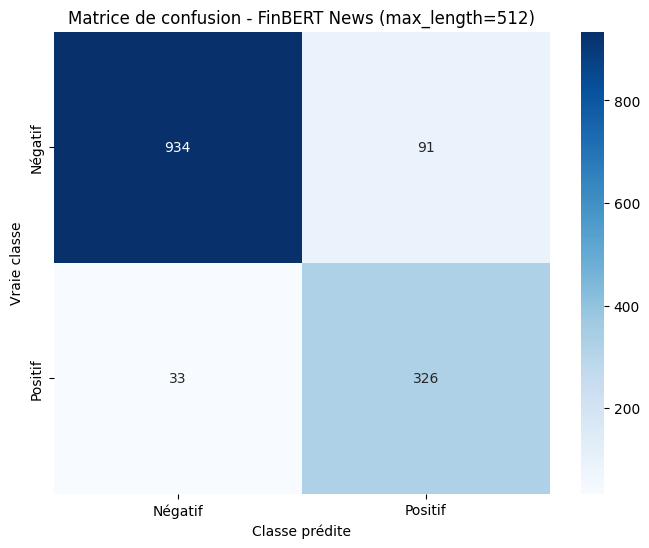

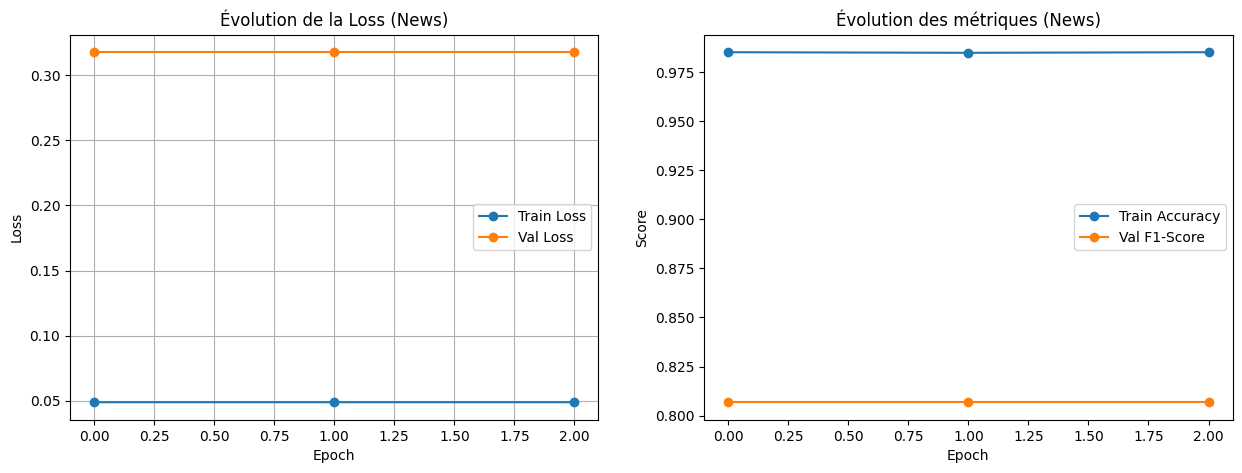

<Figure size 640x480 with 0 Axes>

In [21]:
# 8. Évaluation du modèle News
# Charger le meilleur modèle
model = AutoModelForSequenceClassification.from_pretrained(
    './news_best_finbert_checkpoint',
    num_labels=2,
    use_safetensors=True
)
model.to(device)
model.eval()

# Prédictions finales sur test
_, y_pred, y_true = evaluate(model, test_loader, criterion, device)

evaluate_model(y_true, y_pred, "FinBERT News (max_length=512)")

# Courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Évolution de la Loss (News)')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_f1'], label='Val F1-Score', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Évolution des métriques (News)')

axes[1].legend()
plt.show()

axes[1].grid(True)
plt.tight_layout()


In [22]:
# 9. Sauvegarder le modèle fine-tuné pour News
model.save_pretrained("./news_finbert_sentiment_model", safe_serialization=True)
tokenizer.save_pretrained("./news_finbert_sentiment_model")
print("✓ Modèle News sauvegardé dans ./news_finbert_sentiment_model (format safetensors)")
print("✓ Checkpoint sauvegardé dans ./news_best_finbert_checkpoint")

✓ Modèle News sauvegardé dans ./news_finbert_sentiment_model (format safetensors)
✓ Checkpoint sauvegardé dans ./news_best_finbert_checkpoint
